# Predicting ratings of Google Play Store apps

## Introduction

This notebook aims to predict the ratings of Google Play Store apps based on category, size, number of installs, etc. using the data available on Kaggle.

The data is available [here](https://www.kaggle.com/lava18/google-play-store-apps). The data is collected from the Google Play Store and contains information about the apps such as the category, rating, size, number of reviews, etc.

## Importing the libraries

We will be using the following libraries:
- numpy
- pandas
- matplotlib - for data visualization
- seaborn - for data visualization

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

## Constants

In [54]:
IN_DATA_PATH = 'data/googleplaystore.csv'
OUT_DATA_PATH = 'data/googleplaystore_{df_name}.csv'

## Data acquisition and Preparation

### Getting the data

In [55]:
df_raw = pd.read_csv(IN_DATA_PATH)
df_raw.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### Data preparation

In [56]:
# Check the data types of the columns

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [57]:
# Drop duplicates
df_raw.drop_duplicates(inplace=True)
df_raw.shape

(10358, 13)

We dropped several columns that would not be useful for our analysis. The columns that we dropped are:
- App - the name of the app
- Last Updated - the date when the app was last updated
- Current Ver - the current version of the app
- Android Ver - the minimum Android version required to run the app

These are technical details that we believe would have little to no effect on the rating of the app, assuming that the app is well maintained and can run on the latest version of Android.

In [58]:
# Dropping columns we don't need

df = df_raw.drop(['App', 'Current Ver', 'Android Ver', 'Last Updated'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10358 entries, 0 to 10840
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        10358 non-null  object 
 1   Rating          8893 non-null   float64
 2   Reviews         10358 non-null  object 
 3   Size            10358 non-null  object 
 4   Installs        10358 non-null  object 
 5   Type            10357 non-null  object 
 6   Price           10358 non-null  object 
 7   Content Rating  10357 non-null  object 
 8   Genres          10358 non-null  object 
dtypes: float64(1), object(8)
memory usage: 809.2+ KB


In [59]:
# Dropping null rows

df = df.dropna()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8892 entries, 0 to 10840
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        8892 non-null   object 
 1   Rating          8892 non-null   float64
 2   Reviews         8892 non-null   object 
 3   Size            8892 non-null   object 
 4   Installs        8892 non-null   object 
 5   Type            8892 non-null   object 
 6   Price           8892 non-null   object 
 7   Content Rating  8892 non-null   object 
 8   Genres          8892 non-null   object 
dtypes: float64(1), object(8)
memory usage: 694.7+ KB


Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
dtype: int64

In [60]:
# Genres are a bit messy, so we'll clean them up

# What's the max and min number of genres in a single app?
max_genre_count = df['Genres'].apply(lambda x: len(x.split(';'))).max()
min_genre_count = df['Genres'].apply(lambda x: len(x.split(';'))).min()
print(max_genre_count)
print(min_genre_count)

2
1


In [61]:
# Check if Category is the same as the first genre, if false, what's the difference?
df_genres_compare = df['Genres'].apply(lambda x: x.split(';')[0].upper().replace(' ', '_').replace('&', 'AND'))
df_genres_compare = df_genres_compare == df['Category']

# View rows where the comparison is false
df[df_genres_compare == False]


,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
1653,GAME,4.5,4447388,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure
1654,GAME,4.5,27722264,76M,"1,000,000,000+",Free,0,Everyone 10+,Arcade
1655,GAME,4.4,22426677,74M,"500,000,000+",Free,0,Everyone,Casual
1656,GAME,4.7,254258,23M,"10,000,000+",Free,0,Everyone,Card
1657,GAME,4.5,148897,46M,"10,000,000+",Free,0,Everyone,Casual
...,...,...,...,...,...,...,...,...,...
10820,FAMILY,5.0,22,8.6M,"1,000+",Free,0,Teen,Education
10827,FAMILY,4.2,117,13M,"5,000+",Free,0,Everyone,Education
10834,FAMILY,4.0,7,2.6M,500+,Free,0,Everyone,Education
10836,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education


In [62]:
# It's reasonable to split the genres into 2 columns:
# 1. Primary Genre
# 2. Secondary Genre

df['Primary Genre'] = df['Genres'].apply(lambda x: x.split(';')[0])
df['Secondary Genre'] = df['Genres'].apply(lambda x: x.split(';')[1] if len(x.split(';')) > 1 else None)

# Drop the original Genres column
df = df.drop('Genres', axis = 1)

df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Primary Genre,Secondary Genre
0,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,None
1,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design,Pretend Play
2,ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,None
3,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,None
4,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design,Creativity


In [63]:
# Reviews column
# Convert to float
df['Reviews'] = df['Reviews'].astype(float)

In [64]:
# Process Size column

# Drop 'Varies with device' rows
df = df[df['Size'] != 'Varies with device']

# Convert Size to MB
def convert_size_to_mb(value):
    if pd.isnull(value):
        return value
    elif 'M' in value:
        return float(value.replace('M', '').strip())
    elif 'k' in value:
        return float(value.replace('k', '').strip()) / 1024
    else:
        return value

df['Size'] = df['Size'].apply(convert_size_to_mb)

df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Primary Genre,Secondary Genre
0,ART_AND_DESIGN,4.1,159.0,19.0,"10,000+",Free,0,Everyone,Art & Design,None
1,ART_AND_DESIGN,3.9,967.0,14.0,"500,000+",Free,0,Everyone,Art & Design,Pretend Play
2,ART_AND_DESIGN,4.7,87510.0,8.7,"5,000,000+",Free,0,Everyone,Art & Design,None
3,ART_AND_DESIGN,4.5,215644.0,25.0,"50,000,000+",Free,0,Teen,Art & Design,None
4,ART_AND_DESIGN,4.3,967.0,2.8,"100,000+",Free,0,Everyone,Art & Design,Creativity


In [65]:
# Installs column

# val contains the unique values in the Installs column, sorted in ascending order
val = df["Installs"].unique()
for i in range(len(val)):
    val[i] = int(val[i].replace('+', '').replace(',', ''))
val = np.sort(val)

# Create encoding dictionary
install_encoding = {}
for value in df["Installs"].unique():
    install_encoding[value] = float(np.where(val == int(value.replace('+', '').replace(',', '')))[0][0])

# Encode Installs column
df["Installs"] = df["Installs"].map(install_encoding)

df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Primary Genre,Secondary Genre
0,ART_AND_DESIGN,4.1,159.0,19.0,8.0,Free,0,Everyone,Art & Design,None
1,ART_AND_DESIGN,3.9,967.0,14.0,11.0,Free,0,Everyone,Art & Design,Pretend Play
2,ART_AND_DESIGN,4.7,87510.0,8.7,13.0,Free,0,Everyone,Art & Design,None
3,ART_AND_DESIGN,4.5,215644.0,25.0,15.0,Free,0,Teen,Art & Design,None
4,ART_AND_DESIGN,4.3,967.0,2.8,10.0,Free,0,Everyone,Art & Design,Creativity


In [66]:
# Price column

# Drop '$' and convert to float
df['Price'] = df['Price'].apply(lambda x: float(x.replace('$', '')))
df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Primary Genre,Secondary Genre
0,ART_AND_DESIGN,4.1,159.0,19.0,8.0,Free,0.0,Everyone,Art & Design,None
1,ART_AND_DESIGN,3.9,967.0,14.0,11.0,Free,0.0,Everyone,Art & Design,Pretend Play
2,ART_AND_DESIGN,4.7,87510.0,8.7,13.0,Free,0.0,Everyone,Art & Design,None
3,ART_AND_DESIGN,4.5,215644.0,25.0,15.0,Free,0.0,Teen,Art & Design,None
4,ART_AND_DESIGN,4.3,967.0,2.8,10.0,Free,0.0,Everyone,Art & Design,Creativity


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7424 entries, 0 to 10840
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Category         7424 non-null   object 
 1   Rating           7424 non-null   float64
 2   Reviews          7424 non-null   float64
 3   Size             7424 non-null   float64
 4   Installs         7424 non-null   float64
 5   Type             7424 non-null   object 
 6   Price            7424 non-null   float64
 7   Content Rating   7424 non-null   object 
 8   Primary Genre    7424 non-null   object 
 9   Secondary Genre  386 non-null    object 
dtypes: float64(5), object(5)
memory usage: 638.0+ KB


Numerical variables: **Rating**, Reviews, Size, Price

Categorical variables: Category, Installs, Type, Content Rating, Primary Genre, Secondary Genre

### Data visualization and Exploration

In [68]:
# Checking some descriptive statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,7424.0,4.171309,5.497294e-01,1.000000,4.0,4.3,4.50,5.0
Reviews,7424.0,278773.976024,1.743621e+06,1.000000,99.0,2067.0,36894.75,44893888.0
Size,7424.0,22.747273,2.343512e+01,0.008301,5.1,14.0,33.00,100.0
Installs,7424.0,9.931843,3.211682e+00,0.000000,8.0,10.0,12.00,18.0
Price,7424.0,1.116599,1.770857e+01,0.000000,0.0,0.0,0.00,400.0


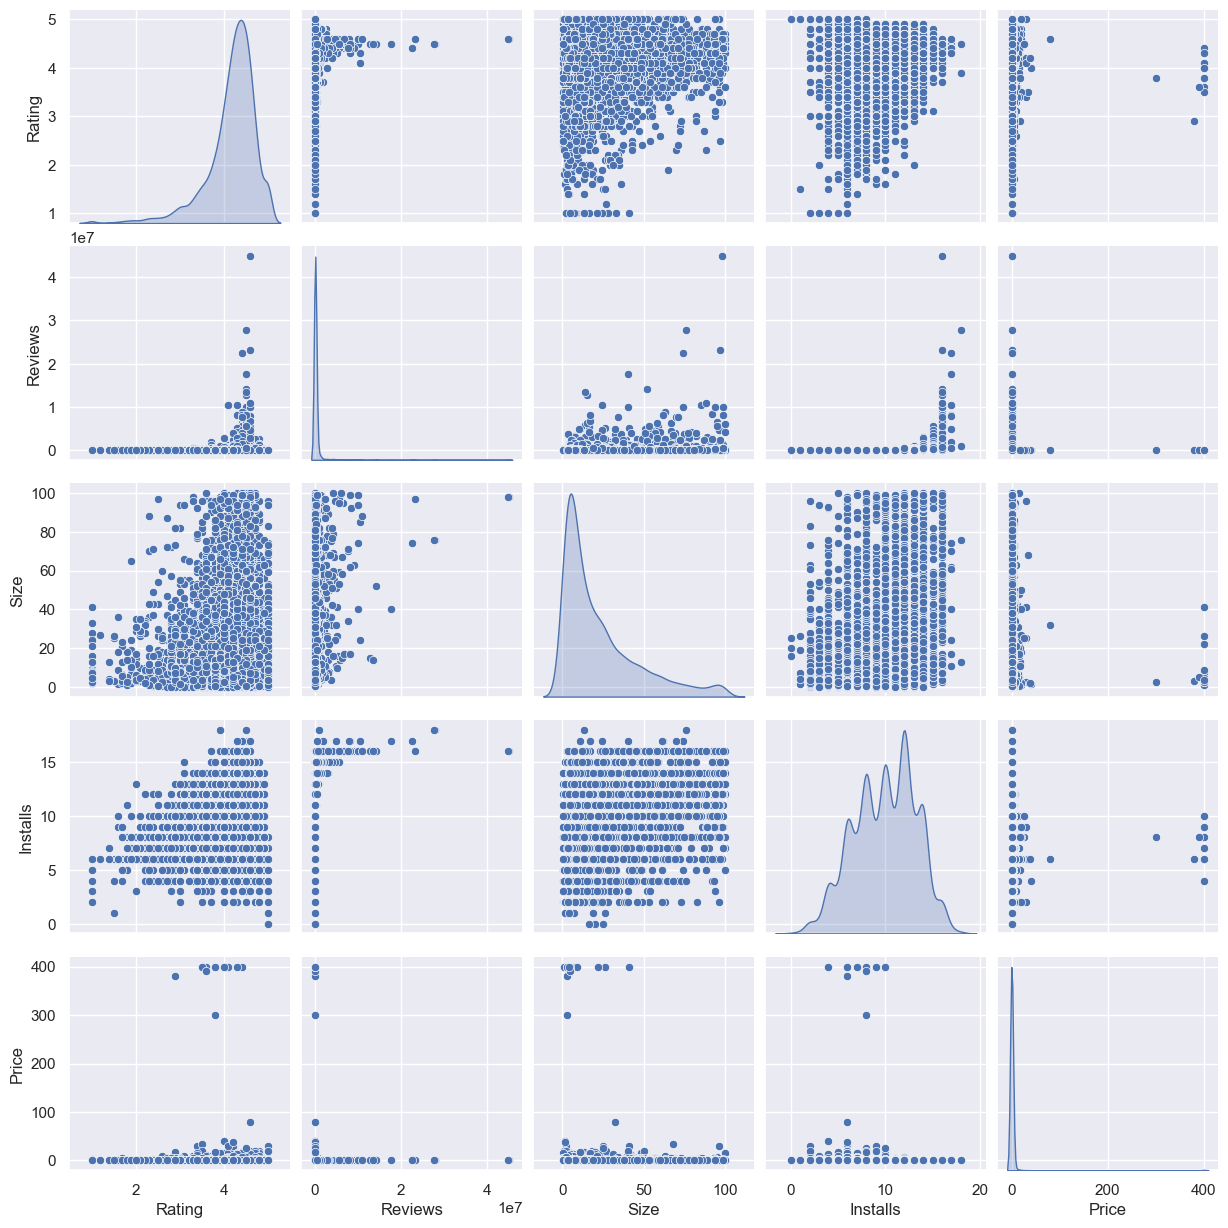

In [69]:
# Visualize numerical variables with pairplot
sns.pairplot(df[['Rating', 'Reviews', 'Size', 'Installs', 'Price']], diag_kind='kde')

**Remarks (Descriptive Univariate Statistics)**

- `Rating` is normally distributed, but with a significant negative skew.
- A large number of apps has 0 review and is free, resulting the distribution of `Price` and `Reviews` to be heavily skewed to the right. The peak of the distribution of both Reviews and Price hovers around 0.
- `Size` of apps is normally distributed, but with a significant positive skew. It means that the majority of apps are small in size, which is expected.
- `Installs` are actually a categorical variable with discrete values, that explains the shape of its distribution. If we smooth the distribution, it would look like a normal distribution.

<Axes: >

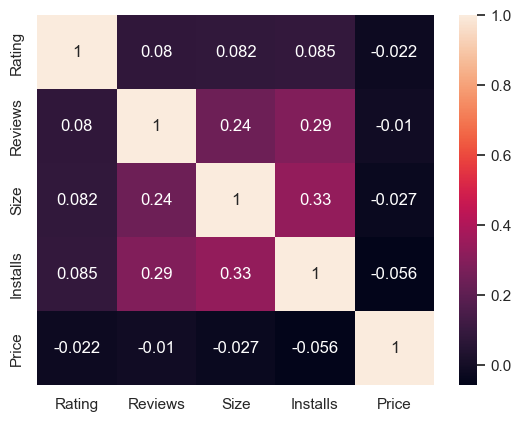

In [70]:
# Draw correlation matrix
corr = df[['Rating', 'Reviews', 'Size', 'Installs', 'Price']].corr()
sns.heatmap(corr, annot=True)

**Remark (Correlation):** 

At first glance, it seems that there is little correlation between numerical predictors and the response variable (rating). There are, however, some interesting trends that we can observe from the plots:
- Apps that have review (>0 reviews) tend to have a higher rating.
- Although smaller apps can achieve high rating (as well as low rating), bigger apps rarely get a low rating.
- Similarly, apps with higher number of installs tend to have a higher rating, or more precisely, they rarely get a low rating.
- The majority of apps are free. Paid apps tend to have a rating of 3.5 - 4.5.
- Low correlation between independent variables and the response variable, suggesting that linear regression models may not be the best choice. We will therefore try to use other models. 

The points listed above suggest that this is a non-linear regression problem, and we should use a model that can handle this kind of problem, such as tree-based model. Hence, we will try **random forest**, **gradient boosting**, as well as **deep learning model**.

<Axes: xlabel='Secondary Genre', ylabel='Rating'>

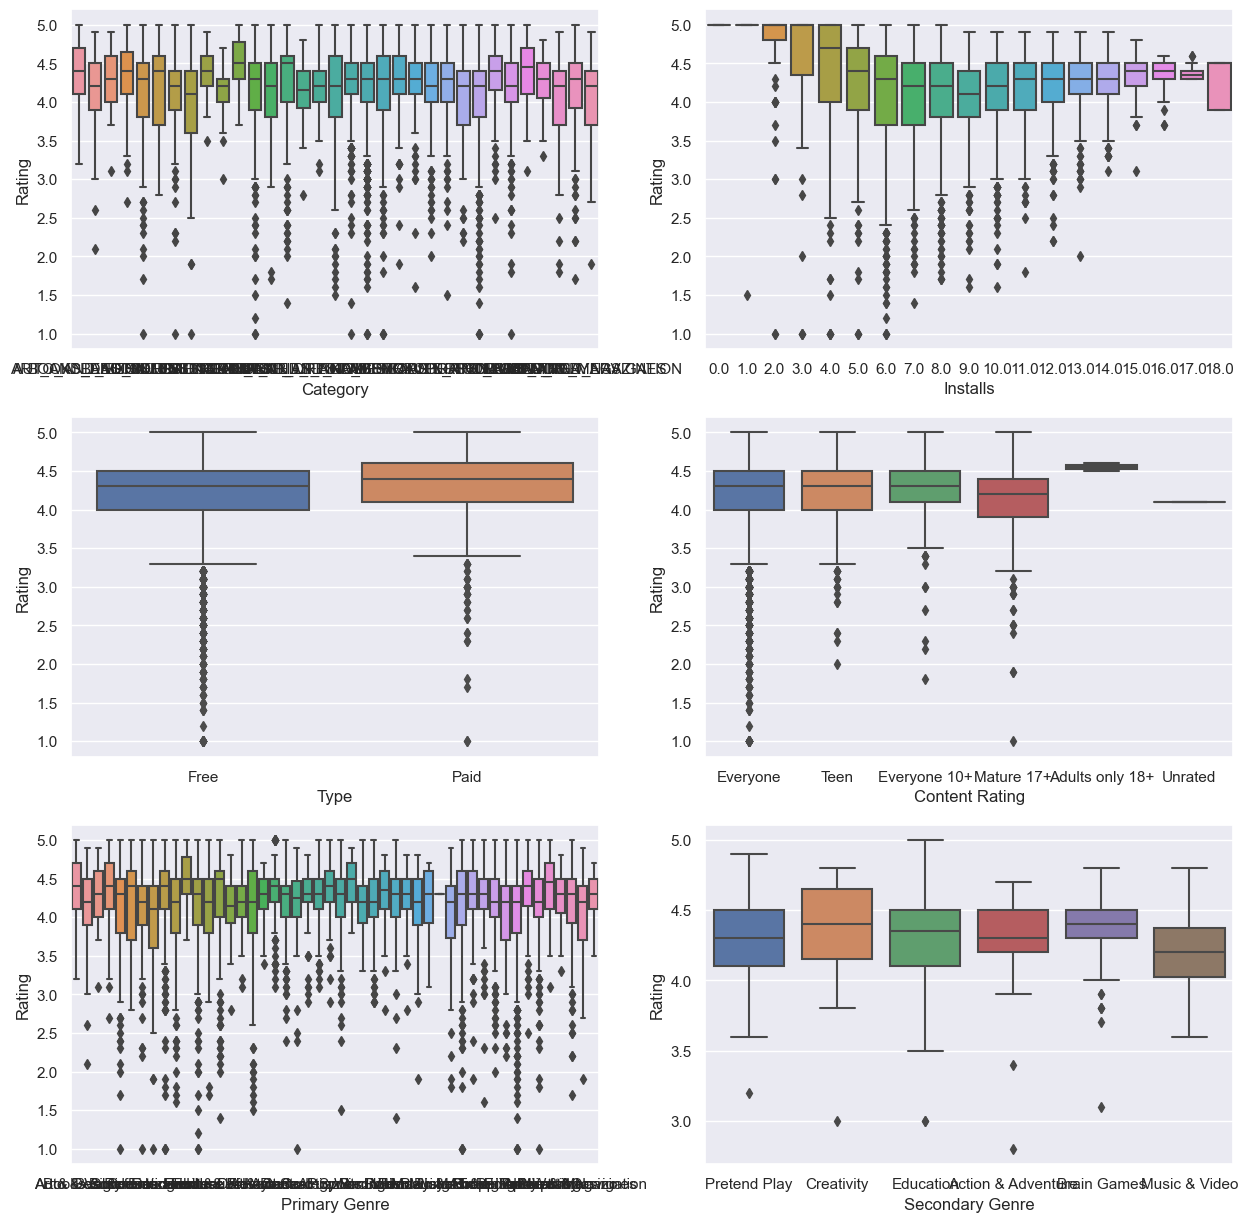

In [71]:
# Plot relationship between categorical variables and Rating
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
sns.boxplot(x='Category', y='Rating', data=df, ax=ax[0, 0])
sns.boxplot(x='Installs', y='Rating', data=df, ax=ax[0, 1])
sns.boxplot(x='Type', y='Rating', data=df, ax=ax[1, 0])
sns.boxplot(x='Content Rating', y='Rating', data=df, ax=ax[1, 1])
sns.boxplot(x='Primary Genre', y='Rating', data=df, ax=ax[2, 0])
sns.boxplot(x='Secondary Genre', y='Rating', data=df, ax=ax[2, 1])

**Remarks (Multivariate Analysis for Categorical Variables)**

- As seen from the graphs, most if not all categorical variables do not have a significant effect on the rating of the app. It is interesting to see factors such as the genre of the app and whether the app is free or paid do not have a significant effect on the rating of the app, which means every kinds of app have the potential to be rated highly.

### Encoding for categorical variables

We will use one-hot encoding for the categorical variables. The purpose of one-hot encoding is to convert categorical variables into a form that could be provided to ML algorithms to achieve better prediction results.

In [72]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Category', 'Type', 'Content Rating', 'Primary Genre', 'Secondary Genre'])
df_encoded.head()

,Rating,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,...,Primary Genre_Trivia,Primary Genre_Video Players & Editors,Primary Genre_Weather,Primary Genre_Word,Secondary Genre_Action & Adventure,Secondary Genre_Brain Games,Secondary Genre_Creativity,Secondary Genre_Education,Secondary Genre_Music & Video,Secondary Genre_Pretend Play
0,4.1,159.0,19.0,8.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967.0,14.0,11.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4.7,87510.0,8.7,13.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644.0,25.0,15.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967.0,2.8,10.0,0.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [73]:
df_encoded.shape

(7424, 100)

## Further process data for ease of use in ML models

This step aims to produce data that is ready to be used and is optimised for training in ML models.

### Splitting the data into training and test sets

We split the whole clean dataset into training set and test set with the ratio 80 : 20.

The result of this step includes 4 dataframes:
- `X_train` - the training set, containing the predictors
- `y_train` - the training set, containing the response variable
- `X_test` - the test set, containing the predictors
- `y_test` - the test set, containing the response variable

In [74]:
# Split data into train and test sets
df_train = df.sample(frac=0.8, random_state=0)
X_train = df_train.drop('Rating', axis=1)
y_train = pd.DataFrame(df_train['Rating'])
df_test = df.drop(df_train.index)
X_test = df_test.drop('Rating', axis=1)
y_test = pd.DataFrame(df_test['Rating'])

In [75]:
# Split data into train and test sets (for df_encoded)
df_train_encoded = df_encoded.sample(frac=0.8, random_state=0)
X_train_encoded = df_train_encoded.drop('Rating', axis=1)
y_train_encoded = pd.DataFrame(df_train_encoded['Rating'])
df_test_encoded = df_encoded.drop(df_train_encoded.index)
X_test_encoded = df_test_encoded.drop('Rating', axis=1)
y_test_encoded = pd.DataFrame(df_test_encoded['Rating'])

### Normalization

Normalization ensures that all numerical variables are on the same scale. Previously, `Reviews`, `Size`, and `Price` vary in scale. Therefore, normalisation may help the model to achieve higher accuracy and converge faster.

In [76]:
# Normalize 3 variables: Reviews, Size, Price on training set

X_train['Reviews'] = (X_train['Reviews'] - X_train['Reviews'].mean()) / X_train['Reviews'].std()
X_train['Size'] = (X_train['Size'] - X_train['Size'].mean()) / X_train['Size'].std()
X_train['Price'] = (X_train['Price'] - X_train['Price'].mean()) / X_train['Price'].std()
X_train.head()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Primary Genre,Secondary Genre
4597,COMMUNICATION,-0.157740,0.453740,10.0,Free,-0.062993,Everyone,Communication,None
9398,FAMILY,-0.080897,-0.728124,14.0,Free,-0.062993,Everyone,Entertainment,Music & Video
725,EDUCATION,-0.154967,-0.022469,12.0,Free,-0.062993,Mature 17+,Education,None
10753,SHOPPING,-0.139815,-0.455386,12.0,Free,-0.062993,Everyone,Shopping,None
8515,TOOLS,-0.090800,-0.875315,14.0,Free,-0.062993,Everyone,Tools,None


In [77]:
# Normalize 3 variables: Reviews, Size, Price on test set
X_test['Reviews'] = (X_test['Reviews'] - X_test['Reviews'].mean()) / X_test['Reviews'].std()
X_test['Size'] = (X_test['Size'] - X_test['Size'].mean()) / X_test['Size'].std()
X_test['Price'] = (X_test['Price'] - X_test['Price'].mean()) / X_test['Price'].std()
X_test.head()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Primary Genre,Secondary Genre
0,ART_AND_DESIGN,-0.165125,-0.188515,8.0,Free,-0.063285,Everyone,Art & Design,None
7,ART_AND_DESIGN,-0.142527,0.216010,12.0,Free,-0.063285,Everyone,Art & Design,None
21,ART_AND_DESIGN,-0.164820,-0.471682,10.0,Free,-0.063285,Everyone,Art & Design,None
25,ART_AND_DESIGN,-0.165105,-0.714397,8.0,Free,-0.063285,Everyone,Art & Design,None
26,ART_AND_DESIGN,-0.152733,0.054200,11.0,Free,-0.063285,Everyone,Art & Design,Creativity


In [78]:
# Normalize 3 variables: Reviews, Size, Price on training set (for df_encoded)

X_train_encoded['Reviews'] = (X_train_encoded['Reviews'] - X_train_encoded['Reviews'].mean()) / X_train_encoded['Reviews'].std()
X_train_encoded['Size'] = (X_train_encoded['Size'] - X_train_encoded['Size'].mean()) / X_train_encoded['Size'].std()
X_train_encoded['Price'] = (X_train_encoded['Price'] - X_train_encoded['Price'].mean()) / X_train_encoded['Price'].std()
X_train_encoded.head()

,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,...,Primary Genre_Trivia,Primary Genre_Video Players & Editors,Primary Genre_Weather,Primary Genre_Word,Secondary Genre_Action & Adventure,Secondary Genre_Brain Games,Secondary Genre_Creativity,Secondary Genre_Education,Secondary Genre_Music & Video,Secondary Genre_Pretend Play
4597,-0.157740,0.453740,10.0,-0.062993,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9398,-0.080897,-0.728124,14.0,-0.062993,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
725,-0.154967,-0.022469,12.0,-0.062993,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10753,-0.139815,-0.455386,12.0,-0.062993,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8515,-0.090800,-0.875315,14.0,-0.062993,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# Normalize 3 variables: Reviews, Size, Price on test set (for df_encoded)
X_test_encoded['Reviews'] = (X_test_encoded['Reviews'] - X_test_encoded['Reviews'].mean()) / X_test_encoded['Reviews'].std()
X_test_encoded['Size'] = (X_test_encoded['Size'] - X_test_encoded['Size'].mean()) / X_test_encoded['Size'].std()
X_test_encoded['Price'] = (X_test_encoded['Price'] - X_test_encoded['Price'].mean()) / X_test_encoded['Price'].std()
X_test_encoded.head()

,Reviews,Size,Installs,Price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,...,Primary Genre_Trivia,Primary Genre_Video Players & Editors,Primary Genre_Weather,Primary Genre_Word,Secondary Genre_Action & Adventure,Secondary Genre_Brain Games,Secondary Genre_Creativity,Secondary Genre_Education,Secondary Genre_Music & Video,Secondary Genre_Pretend Play
0,-0.165125,-0.188515,8.0,-0.063285,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-0.142527,0.216010,12.0,-0.063285,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,-0.164820,-0.471682,10.0,-0.063285,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,-0.165105,-0.714397,8.0,-0.063285,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,-0.152733,0.054200,11.0,-0.063285,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Export the data

In [80]:
# Export X_train, y_train, X_test, y_test to csv files
X_train.to_csv(OUT_DATA_PATH.format(df_name = "X_train"), index=False)
y_train.to_csv(OUT_DATA_PATH.format(df_name = "y_train"), index=False)
X_test.to_csv(OUT_DATA_PATH.format(df_name = "X_test"), index=False)
y_test.to_csv(OUT_DATA_PATH.format(df_name = "y_test"), index=False)

In [81]:
# Export X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded to csv files
X_train_encoded.to_csv(OUT_DATA_PATH.format(df_name = "X_train_encoded"), index=False)
y_train_encoded.to_csv(OUT_DATA_PATH.format(df_name = "y_train_encoded"), index=False)
X_test_encoded.to_csv(OUT_DATA_PATH.format(df_name = "X_test_encoded"), index=False)
y_test_encoded.to_csv(OUT_DATA_PATH.format(df_name = "y_test_encoded"), index=False)